In [43]:
# from IPython.display import display
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import anndata

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Download embeddings from S3 or Google Drive and put it in `../data`

Both Anndata objects have the same samples—namely, the EGFR-related samples. Controls included.

- `rxrx_adata` represents simply the embeddings given to us by Recursion. 
- `cp_adata` represents a CellProfiler pipeline run on the same samples.

In [44]:
# Read the data
rxrx_adata = anndata.read_h5ad("../data/rxrx3_embeddings.h5ad")
print(rxrx_adata.shape)  # 128 dimensions

cp_adata = anndata.read_h5ad("../data/rxrx3_cellprofiler.h5ad")
print(cp_adata.shape)  # 6.5k dimensions, many low-variance, correlated, bad, etc.

# Reformat treatment_column slightly
rxrx_adata.obs['treatment'] = rxrx_adata.obs['treatment'].str.replace('EGFR_guide_\d+', 'EGFR_KO', regex=True)
cp_adata.obs['treatment'] = cp_adata.obs['treatment'].str.replace('EGFR_guide_\d+', 'EGFR_KO', regex=True)



(1149, 128)
(1149, 6536)


# Run and plot PCA

In [45]:
def run_pca(adata, n_components=50, standardize=True, copy=False, key_added='X_pca'):
    if copy:
        adata = adata.copy()
    X = adata.X.copy()
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)

    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    adata.obsm[key_added] = X_pca
    adata.uns['pca'] = {
        'variance_ratio': pca.explained_variance_ratio_,
        'variance': pca.explained_variance_,
        'total_variance': sum(pca.explained_variance_ratio_)
    }
    return adata

def plot_pca(adata, basis='X_pca', color='treatment', dims=[0, 1], title='PCA of Cell Profiles'):
    # get the pca coordinates
    X_pca = adata.obsm[basis]
    
    # get explained variance
    variance_ratio = adata.uns['pca']['variance_ratio']
    
    # axis labels with explained variance
    x_label = f"PC{dims[0] + 1} ({variance_ratio[dims[0]] * 100:.2f}%)"
    y_label = f"PC{dims[1] + 1} ({variance_ratio[dims[1]] * 100:.2f}%)"
    
    # plot
    sns.scatterplot(
        x=X_pca[:, dims[0]], 
        y=X_pca[:, dims[1]], 
        hue=adata.obs[color]
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# rxrx3 embeddings

AnnData object with n_obs × n_vars = 1149 × 128
    obs: 'experiment_name', 'plate', 'address', 'gene', 'treatment', 'SMILES', 'concentration', 'perturbation_type', 'cell_type', 'directory'
    uns: 'pca'
    obsm: 'X_pca'


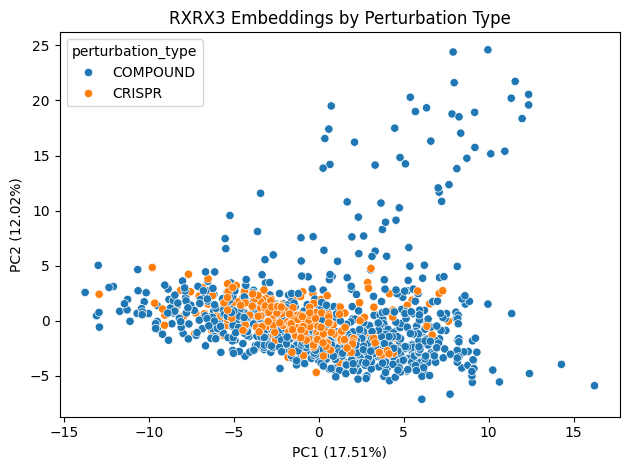

In [46]:
run_pca(rxrx_adata)
print(rxrx_adata)  # Note the PCA embeddings are in `rxrx_adata.obsm['X_pca']`
plot_pca(rxrx_adata, basis='X_pca', color='perturbation_type', dims=[0, 1], title='RXRX3 Embeddings by Perturbation Type')

## CellProfiler

AnnData object with n_obs × n_vars = 1149 × 6536
    obs: 'experiment_name', 'plate', 'address', 'gene', 'treatment', 'SMILES', 'concentration', 'perturbation_type', 'cell_type', 'directory'
    uns: 'pca'
    obsm: 'X_pca'


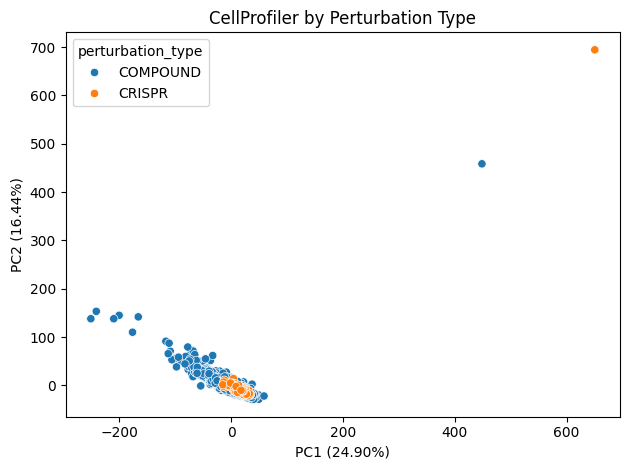

In [47]:
run_pca(cp_adata)
print(cp_adata)  # Note the PCA embeddings are in `cp_adata.obsm['X_pca']`
plot_pca(cp_adata, basis='X_pca', color='perturbation_type', dims=[0, 1], title='CellProfiler by Perturbation Type')


# ignore below~

# EGFR KO related index

In [ ]:
egfr_index = cp_adata.obs['perturbation_type'] == 'CRISPR'
egfr_embeddings_adata = rxrx_adata[egfr_index]
egfr_cellprofiler_adata = cp_adata[egfr_index]

# Plot PCA
plot_pca(egfr_embeddings_adata, basis='X_pca', color='treatment', dims=[0, 1], title='RXRX3 EGFR KO Embeddings')
plot_pca(egfr_cellprofiler_adata, basis='X_pca', color='treatment', dims=[0, 1], title='CellProfiler EGFR KO')

In [ ]:
pd.DataFrame(egfr_cellprofiler_adata.obsm['X_pca']).iloc[:, :2].sort_values(by=0)
egfr_cellprofiler_adata.X[235]  # lmao the sample is all NaNs

# Select just EGFR_KO related samples

In [ ]:
egfr_embeddings_adata = embeddings_adata[embeddings_adata.obs['perturbation_type'] == 'CRISPR']
egfr_embeddings_adata

In [ ]:
egfr_cellprofiler_adata = cellprofiler_adata[cellprofiler_adata.obs['perturbation_type'] == 'CRISPR']
egfr_cellprofiler_adata

In [ ]:
def run_pca(adata, n_components=50, standardize=True, copy=False, key_added='X_pca'):
    if copy:
        adata = adata.copy()
    X = adata.X.copy()
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)

    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    adata.obsm[key_added] = X_pca
    adata.uns['pca'] = {
        'variance_ratio': pca.explained_variance_ratio_,
        'variance': pca.explained_variance_,
        'total_variance': sum(pca.explained_variance_ratio_)
    }
    return adata

run_pca(egfr_cellprofiler_adata)

In [ ]:
def plot_pca(adata, basis='X_pca', color='treatment', dims=[0, 1], title='PCA of Cell Profiles'):
    X_pca = adata.obsm[basis]
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=adata.obs[color])
    plt.title(title)
    plt.show()

plot_pca(egfr_cellprofiler_adata, basis='X_pca', color='treatment', dims=[0, 1], title='PCA of Cell Profiles')

In [ ]:
import umap

def run_umap(
    adata: AnnData,
    use_rep: str = 'X_pca',
    n_components: int = 2,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    random_state: int = 42,
    copy: bool = False,
    key_added: str = 'X_umap'
) -> AnnData:
    """
    Run UMAP on AnnData object.
    
    Parameters
    ----------
    adata : AnnData
        Input data
    use_rep : str
        Key for representation to use as UMAP input (usually 'X_pca')
    n_components : int
        Number of UMAP dimensions
    n_neighbors : int
        UMAP parameter for local neighborhood size
    min_dist : float
        UMAP parameter for minimum distance between points
    random_state : int
        Random seed
    copy : bool
        Return a copy instead of writing to adata
    key_added : str
        Key under which to add UMAP coordinates to adata.obsm
        
    Returns
    -------
    AnnData
        Modified AnnData object
    """
    if copy:
        adata = adata.copy()
    
    # Check if the requested representation exists
    if use_rep not in adata.obsm:
        raise ValueError(f"Could not find '{use_rep}' in .obsm")
    
    # Get data for UMAP
    X = adata.obsm[use_rep]
    
    # Run UMAP
    logger.info(f"Running UMAP on {use_rep}...")
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    X_umap = reducer.fit_transform(X)
    
    # Store results
    adata.obsm[key_added] = X_umap
    
    # Store UMAP parameters
    adata.uns['umap'] = {
        'params': {
            'n_components': n_components,
            'n_neighbors': n_neighbors,
            'min_dist': min_dist
        }
    }
    
    logger.info(f"UMAP embedding shape: {X_umap.shape}")
    
    return adata

run_umap(egfr_cellprofiler_adata)

In [21]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from anndata import AnnData
from typing import Optional, List, Union

def plot_dim_reduction(
    adata: AnnData,
    basis: str = 'X_umap',
    color: Union[str, List[str]] = None,
    dims: list = [0, 1],
    hover_data: List[str] = None,
    title: Optional[str] = None,
    width: int = 800,
    height: int = 800,
    point_size: int = 8,
    opacity: float = 0.7,
) -> go.Figure:
    """
    Plot PCA or UMAP using plotly.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix
    basis : str
        'X_pca' or 'X_umap'
    color : str or list of str
        Column(s) in adata.obs for coloring points
    dims : list
        Which dimensions to plot, e.g. [0,1] for first two components
    hover_data : list
        Additional columns from adata.obs to show in hover
    title : str
        Plot title
    width : int
        Plot width
    height : int
        Plot height
    point_size : int
        Size of points
    opacity : float
        Point opacity
        
    Returns
    -------
    plotly.graph_objects.Figure
    """
    # Check if basis exists
    if basis not in adata.obsm:
        raise ValueError(f"Could not find '{basis}' in .obsm")
    
    # Create dataframe for plotting
    plot_df = pd.DataFrame(
        adata.obsm[basis][:, dims],
        columns=[f"{basis.split('_')[1].upper()}{i+1}" for i in dims]
    )
    
    # Add coloring data
    if color is not None:
        if isinstance(color, str):
            color = [color]
        for col in color:
            if col in adata.obs:
                plot_df[col] = adata.obs[col]
    
    # Add hover data
    if hover_data is not None:
        for col in hover_data:
            if col in adata.obs and col not in plot_df:
                plot_df[col] = adata.obs[col]
    
    # Set up title
    if title is None:
        title = f"{basis.split('_')[1].upper()} Visualization"
        if color:
            title += f" (colored by {', '.join(color)})"
    
    # Create plot
    fig = px.scatter(
        plot_df,
        x=plot_df.columns[0],
        y=plot_df.columns[1],
        color=color[0] if color else None,
        hover_data=hover_data,
        title=title,
        width=width,
        height=height,
    )
    
    # Update layout
    fig.update_traces(
        marker=dict(size=point_size),
        opacity=opacity
    )
    
    fig.update_layout(
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.02
        )
    )
    
    return fig

def plot_pca_variance(
    adata: AnnData,
    n_components: int = 50,
    width: int = 800,
    height: int = 400
) -> go.Figure:
    """
    Plot PCA variance explained.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with PCA results
    n_components : int
        Number of components to plot
    width : int
        Plot width
    height : int
        Plot height
        
    Returns
    -------
    plotly.graph_objects.Figure
    """
    if 'pca' not in adata.uns:
        raise ValueError("No PCA results found in .uns['pca']")
    
    var_ratio = adata.uns['pca']['variance_ratio']
    cumsum = np.cumsum(var_ratio)
    
    # Create figure with secondary y-axis
    fig = go.Figure()
    
    # Add bars for individual variance
    fig.add_trace(
        go.Bar(
            x=list(range(1, len(var_ratio) + 1)),
            y=var_ratio,
            name='Individual',
            opacity=0.7
        )
    )
    
    # Add line for cumulative variance
    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(cumsum) + 1)),
            y=cumsum,
            name='Cumulative',
            yaxis='y2'
        )
    )
    
    # Update layout
    fig.update_layout(
        title='PCA Variance Explained',
        xaxis=dict(title='Principal Component'),
        yaxis=dict(title='Individual Variance Ratio'),
        yaxis2=dict(
            title='Cumulative Variance Ratio',
            overlaying='y',
            side='right',
            range=[0, 1]
        ),
        width=width,
        height=height,
        template='plotly_white',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.02
        ),
        hovermode='x unified'
    )
    
    return fig

In [ ]:
# Run PCA
run_pca(
    cellprofiler_adata, 
    n_components=50, 
    standardize=True,
    copy=False, 
    key_added='X_pca'
)

plot_dim_reduction(cellprofiler_adata, basis='X_pca', color='treatment', dims=[0, 1], title='PCA of Cell Profiles')
# plot_pca_variance(cellprofiler_adata)
# adata
# adata.obsm['X_pca']
# sns.scatterplot(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1], hue=adata.obs['gene'])

In [ ]:
cellprofiler_adata, pca = run_pca(
    cellprofiler_adata, 
    n_components=50, 
    standardize=True,
    copy=True, 
    key_added='X_pca'
)

plot_pca_variance(cellprofiler_adata)


In [ ]:
embeddings_adata, pca = run_pca(
    embeddings_adata, 
    n_components=50, 
    standardize=True,
    copy=True, 
    key_added='X_pca'
)

sns.scatterplot(x=embeddings_adata.obsm['X_pca'][:, 0], y=embeddings_adata.obsm['X_pca'][:, 1], hue=embeddings_adata.obs['gene'])

In [ ]:

# Now plot PCA
fig_pca = plot_dim_reduction(
    adata,  # Now using the AnnData object, not the tuple
    basis='X_pca',
    color='gene',
    dims=[0, 1],
    title='PCA of Cell Profiles'
)
fig_pca.show()

# Plot PCA variance
fig_var = plot_pca_variance(adata)
fig_var.show()

In [ ]:
import plotly.express as px

# Count occurrences
grouped_counts = pd.DataFrame(
    embeddings_adata.obs.groupby(['perturbation_type', 'treatment']).size()
).reset_index()
grouped_counts.columns = ['perturbation_type', 'treatment', 'count']

# Create stacked bar plot with plotly
fig = px.bar(
    grouped_counts, 
    x='perturbation_type',
    y='count',
    color='treatment',
    title='Sample Counts by Perturbation Type and Treatment',
    labels={
        'perturbation_type': 'Perturbation Type',
        'count': 'Count',
        'treatment': 'Treatment'
    }
)

# Update layout
fig.update_layout(
    barmode='stack',
    xaxis_tickangle=-45,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02
    ),
    margin=dict(r=150)  # Add right margin for legend
)

fig.show()

In [ ]:

embeddings_adata.obs['group'] = embeddings_adata.obs['perturbation_type'].astype(str) + '_' + embeddings_adata.obs['treatment'].astype(str)

cellprofiler_adata = anndata.read_h5ad("../data/rxrx3_cellprofiler.h5ad")

# Convert categorical columns to string before operations
treatment_str = cellprofiler_adata.obs['treatment'].astype(str)
gene_str = cellprofiler_adata.obs['gene'].astype(str)

# Create group column
# cellprofiler_adata.obs['group'] = treatment_str + '_' + gene_str.where(gene_str != 'nan', treatment_str)

display(embeddings_adata)
display(cellprofiler_adata.obs)

In [ ]:
# 1. First clean both datasets
def clean_data(adata):
    """Clean AnnData by handling inf/nan and standardizing."""
    X_clean = adata.X.copy()
    
    # Replace inf with nan
    X_clean = np.where(np.isinf(X_clean), np.nan, X_clean)
    
    # Fill nan with column medians
    for col in range(X_clean.shape[1]):
        col_median = np.nanmedian(X_clean[:, col])
        X_clean[np.isnan(X_clean[:, col]), col] = col_median
    
    # Standardize each column
    for col in range(X_clean.shape[1]):
        mean = np.mean(X_clean[:, col])
        std = np.std(X_clean[:, col])
        if std > 0:  # avoid division by zero
            X_clean[:, col] = (X_clean[:, col] - mean) / std
    X_clean = np.nan_to_num(X_clean)
    return X_clean

# Clean both datasets
X1_clean = clean_data(embeddings_adata)
X2_clean = clean_data(cellprofiler_adata)

from sklearn.decomposition import PCA

# Reduce dimensions before CCA
pca1 = PCA(n_components=50)
pca2 = PCA(n_components=50)

X1_reduced = pca1.fit_transform(X1_clean)
X2_reduced = pca2.fit_transform(X2_clean)

# Then do CCA on reduced data
cca = CCA(n_components=50)
X1_cca, X2_cca = cca.fit_transform(X1_reduced, X2_reduced)



In [32]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd
from scipy.sparse import issparse

def select_features(
    adata, 
    variance_threshold=0.01, 
    correlation_threshold=0.95,
    n_mutual_info_features=None,
    target_col='gene',
):
    """
    Select features based on variance, correlation, and mutual information.
    """
    stats = {}
    
    # Convert to pandas for easier manipulation
    df = pd.DataFrame(adata.X.toarray() if issparse(adata.X) else adata.X, 
                     columns=adata.var_names)
    stats['initial_features'] = df.shape[1]
    
    # 1. Variance filtering
    print("Performing variance filtering...")
    variances = df.var()
    high_var_features = variances[variances > variance_threshold].index.tolist()
    stats['after_variance'] = len(high_var_features)
    print(f"Features after variance filtering: {stats['after_variance']}")
    
    # 2. Correlation filtering
    print("Performing correlation filtering...")
    df_highvar = df[high_var_features]
    corr_matrix = df_highvar.corr().abs()
    
    # Remove upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = [column for column in upper.columns 
               if any(upper[column] > correlation_threshold)]
    
    uncorrelated_features = [f for f in high_var_features if f not in to_drop]
    stats['after_correlation'] = len(uncorrelated_features)
    print(f"Features after correlation filtering: {stats['after_correlation']}")
    
    # 3. Mutual information scoring
    if n_mutual_info_features is not None:
        print("Calculating mutual information scores...")
        df_uncorr = df[uncorrelated_features]
        
        # Handle NaN values explicitly here
        print("Handling NaN values...")
        df_clean = df_uncorr.fillna(df_uncorr.mean())
        
        # Convert target to categorical if it's not already
        target = pd.Categorical(adata.obs[target_col]).codes
        
        mi_scores = mutual_info_classif(df_clean, target)
        
        # Create feature importance Series
        feature_importance = pd.Series(
            mi_scores,
            index=uncorrelated_features
        ).sort_values(ascending=False)
        
        # Select top features
        selected_features = feature_importance.index[:min(n_mutual_info_features, 
                                                        len(uncorrelated_features))].tolist()
        
        # Store top feature information in a simpler format
        stats['top_features'] = [
            (feature, score) for feature, score in 
            zip(feature_importance.index[:10], feature_importance.values[:10])
        ]
        
        stats['final_features'] = len(selected_features)
    else:
        selected_features = uncorrelated_features
        stats['final_features'] = len(selected_features)
    
    print(f"Final number of features: {stats['final_features']}")
    
    return selected_features, stats

def print_feature_selection_stats(stats):
    """Print feature selection statistics in a readable format."""
    print("\nFeature Selection Statistics:")
    print("-" * 50)
    print(f"Initial features: {stats['initial_features']}")
    print(f"After variance filtering: {stats['after_variance']} "
          f"({stats['after_variance']/stats['initial_features']*100:.1f}%)")
    print(f"After correlation filtering: {stats['after_correlation']} "
          f"({stats['after_correlation']/stats['initial_features']*100:.1f}%)")
    print(f"Final features: {stats['final_features']} "
          f"({stats['final_features']/stats['initial_features']*100:.1f}%)")
    
    if 'top_features' in stats:
        print("\nTop 10 features by mutual information:")
        print("-" * 50)
        for i, (feature, importance) in enumerate(stats['top_features'], 1):
            print(f"{i}. {feature}: {importance:.4f}")

In [ ]:
# Select features
selected_features, stats = select_features(
    embeddings_adata,
    variance_threshold=0.20,        # Absolute variance threshold that worked before
    correlation_threshold=0.9,     # Remove highly correlated features
    n_mutual_info_features=1000,    # Optional: select top 1000 features by mutual information
    target_col='treatment'
)

# Print statistics
print_feature_selection_stats(stats)

# Create new AnnData with selected features
adata_selected = embeddings_adata[:, selected_features]
print(f"\nFinal AnnData shape: {adata_selected.shape}")

sns.clustermap(adata_selected.to_df().corr())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distributions(adata, features, group_by='group', n_cols=2):
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        ax = axes[i]
        # Create violin plot
        sns.violinplot(
            data=adata.to_df().join(adata.obs[group_by]),
            x=group_by,
            y=feature,
            ax=ax
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_title(f'{feature}')
    
    plt.tight_layout()
    return fig

# Plot top 6 features
top_features = selected_features[:6]  # Using the top 6 from our mutual information results
fig = plot_feature_distributions(adata_selected, top_features)

# Let's also look at correlations between these features
correlation_matrix = adata_selected[:, top_features].to_df().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between top features')
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# First just try a simple plot for one feature
feature = selected_features[0]  # First feature
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=adata_selected.obs, 
    x='perturbation_type',
    y=adata_selected[:, feature].X.flatten()
)
plt.title(feature)
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
adata_selected[adata_selected.obs['perturbation_type'] == 'CRISPR', :].obs


In [ ]:
cellprofiler_adata.var_names.str.split('_').str[0].unique()

In [6]:
import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Union, List
import logging

def perform_pca(
    adata: AnnData,
    n_components: int = 50,
    use_scaled: bool = True,
    copy: bool = False
) -> AnnData:
    """
    Perform PCA on AnnData object.
    
    Parameters
    ----------
    adata : AnnData
        Input data
    n_components : int
        Number of PCA components to compute
    use_scaled : bool
        If True, use scaled data (adata.X) directly; if False, perform standard scaling
    copy : bool
        If True, return a copy of AnnData with PCA results
        
    Returns
    -------
    AnnData with PCA results in obsm['X_pca'] and var['pca_loadings']
    """
    if copy:
        adata = adata.copy()
    
    # Get data matrix
    X = adata.X
    X = np.nan_to_num(X)
    
    # Scale if needed
    if not use_scaled:
        X = StandardScaler().fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=min(n_components, min(X.shape)))
    X_pca = pca.fit_transform(X)
    
    # Store results
    adata.obsm['X_pca'] = X_pca
    adata.varm['pca_loadings'] = pca.components_.T
    
    # Store variance explained
    adata.uns['pca'] = {
        'variance_ratio': pca.explained_variance_ratio_,
        'variance': pca.explained_variance_
    }
    
    return adata

def perform_umap(
    adata: AnnData,
    n_components: int = 2,
    use_pca: bool = True,
    n_pca_components: Optional[int] = None,
    copy: bool = False,
    **umap_kwargs
) -> AnnData:
    """
    Perform UMAP on AnnData object.
    
    Parameters
    ----------
    adata : AnnData
        Input data
    n_components : int
        Number of UMAP dimensions
    use_pca : bool
        If True, run UMAP on PCA results
    n_pca_components : int, optional
        Number of PCA components to use for UMAP
    copy : bool
        If True, return a copy of AnnData
    **umap_kwargs
        Additional arguments passed to UMAP
        
    Returns
    -------
    AnnData with UMAP results in obsm['X_umap']
    """
    if copy:
        adata = adata.copy()
    
    # Get input data for UMAP
    if use_pca:
        if 'X_pca' not in adata.obsm:
            adata = perform_pca(adata, n_components=n_pca_components or 50)
        X = adata.obsm['X_pca']
        if n_pca_components:
            X = X[:, :n_pca_components]
    else:
        X = adata.X
    
    # Perform UMAP
    reducer = umap.UMAP(n_components=n_components, **umap_kwargs)
    X_umap = reducer.fit_transform(X)
    
    # Store results
    adata.obsm['X_umap'] = X_umap
    
    return adata

def plot_dim_reduction(
    adata: AnnData,
    basis: str = 'umap',
    color_by: Union[str, List[str]] = None,
    shape_by: Optional[str] = None,
    components: tuple = (0, 1),
    figsize: tuple = (10, 10),
    title: Optional[str] = None,
    save: Optional[str] = None,
    **kwargs
) -> None:
    """
    Plot dimensionality reduction results with colors and shapes.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix
    basis : str
        'pca' or 'umap'
    color_by : str or list of str
        Observation column(s) to use for coloring
    shape_by : str, optional
        Observation column to use for point shapes
    components : tuple
        Which components to plot (zero-based)
    figsize : tuple
        Figure size
    title : str, optional
        Plot title
    save : str, optional
        Path to save figure
    **kwargs
        Additional arguments passed to plt.scatter
    """
    # Get the embedding
    basis_key = f'X_{basis.lower()}'
    if basis_key not in adata.obsm:
        raise ValueError(f"Data does not contain {basis} results. Run perform_{basis} first.")
    
    X_dim = adata.obsm[basis_key]
    
    # Handle multiple color variables
    if isinstance(color_by, str):
        color_by = [color_by]
    
    n_plots = len(color_by) if color_by else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(figsize[0]*n_plots, figsize[1]))
    if n_plots == 1:
        axes = [axes]
    
    for ax, color_var in zip(axes, color_by or [None]):
        # Get color values
        if color_var is not None:
            if color_var not in adata.obs:
                raise ValueError(f"Color variable {color_var} not found in observations")
            c = adata.obs[color_var]
        else:
            c = None
        
        # Get shape values
        if shape_by is not None:
            if shape_by not in adata.obs:
                raise ValueError(f"Shape variable {shape_by} not found in observations")
            markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'h', '8']
            unique_shapes = adata.obs[shape_by].unique()
            shape_map = dict(zip(unique_shapes, markers[:len(unique_shapes)]))
            
            # Plot each shape category separately
            for shape_val, marker in shape_map.items():
                mask = adata.obs[shape_by] == shape_val
                ax.scatter(
                    X_dim[mask, components[0]],
                    X_dim[mask, components[1]],
                    c=c[mask] if c is not None else None,
                    marker=marker,
                    label=shape_val,
                    **kwargs
                )
        else:
            ax.scatter(
                X_dim[:, components[0]],
                X_dim[:, components[1]],
                c=c,
                **kwargs
            )
        
        # Add labels and title
        ax.set_xlabel(f'{basis.upper()} {components[0]+1}')
        ax.set_ylabel(f'{basis.upper()} {components[1]+1}')
        if color_var:
            ax.set_title(f'{basis.upper()} - colored by {color_var}')
        
        # Add legend if using shapes
        if shape_by:
            ax.legend(title=shape_by)
        
        # Add colorbar if using continuous colors
        if c is not None and not isinstance(c.dtype, pd.CategoricalDtype):
            plt.colorbar(ax.collections[0], ax=ax, label=color_var)
    
    if title:
        fig.suptitle(title)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save, bbox_inches='tight', dpi=300)

In [ ]:
adata = adata_selected[adata_selected.obs['perturbation_type'] == 'CRISPR', :].copy()

adata_selected_pca = perform_pca(adata_selected, n_components=50)
adata_selected_umap = perform_umap(adata_selected_pca, n_components=2, n_neighbors=15, min_dist=0.1)

# Plot UMAP with different colorings
plot_dim_reduction(
    adata,
    basis='umap',
    color_by=['gene', 'plate'],  # Will create two subplots
    shape_by='cell_type',
    figsize=(12, 6)
)

# Plot PCA
plot_dim_reduction(
    adata,
    basis='pca',
    color_by='gene',
    components=(0, 1),  # Plot first two components
    figsize=(10, 10)
)

# You can also plot variance explained by PCA
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(adata.uns['pca']['variance_ratio']))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Variance Explained')


In [53]:
import numpy as np
import pandas as pd
from scipy import stats
from anndata import AnnData
from typing import Optional, Tuple, List
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AnnDataFeatureSelector:
    """Select features based on variance and correlation thresholds."""
    
    def __init__(
        self,
        variance_percentile: float = 10.0,
        correlation_threshold: float = 0.95
    ):
        """
        Parameters
        ----------
        variance_percentile : float
            Remove features with variance below this percentile
        correlation_threshold : float
            Remove one of each pair of features correlated above this threshold
        """
        self.variance_percentile = variance_percentile
        self.correlation_threshold = correlation_threshold
        
    def fit_transform(self, adata: AnnData, copy: bool = True) -> AnnData:
        """
        Select features based on variance and correlation.
        
        Parameters
        ----------
        adata : AnnData
            Input data
        copy : bool
            Whether to modify in place
            
        Returns
        -------
        AnnData
            Filtered data
        """
        if copy:
            adata = adata.copy()
        
        # Calculate variances
        variances = np.nanvar(adata.X, axis=0)
        var_threshold = np.nanpercentile(variances, self.variance_percentile)
        high_var_mask = variances > var_threshold
        
        logger.info(f"Features before variance filtering: {adata.n_vars}")
        adata = adata[:, high_var_mask]
        logger.info(f"Features after variance filtering: {adata.n_vars}")
        
        # Handle correlations
        corr_matrix = np.corrcoef(np.nan_to_num(adata.X, nan=0).T)
        np.fill_diagonal(corr_matrix, 0)
        
        # Find features to remove due to high correlation
        features_to_remove = set()
        for i in range(corr_matrix.shape[0]):
            if i not in features_to_remove:
                # Find features that correlate too much with feature i
                corr_features = np.where(np.abs(corr_matrix[i]) > self.correlation_threshold)[0]
                # Add correlated features to removal set
                features_to_remove.update(corr_features)
                # Keep feature i
                if i in features_to_remove:
                    features_to_remove.remove(i)
        
        # Create mask for remaining features
        keep_mask = np.ones(adata.n_vars, dtype=bool)
        keep_mask[list(features_to_remove)] = False
        
        logger.info(f"Features after correlation filtering: {np.sum(keep_mask)}")
        
        # Apply final feature selection
        adata = adata[:, keep_mask]
        
        return adata

class AnnDataNormalizer:
    """Normalize AnnData features using robust methods."""
    
    def __init__(self, method: str = 'mad'):
        """
        Parameters
        ----------
        method : str
            'mad' for Median Absolute Deviation scaling
            'robust' for scaling based on quantiles
        """
        valid_methods = ['mad', 'robust']
        if method not in valid_methods:
            raise ValueError(f"method must be one of {valid_methods}")
        self.method = method
    
    def fit_transform(self, adata: AnnData, copy: bool = True) -> AnnData:
        """
        Normalize the data.
        
        Parameters
        ----------
        adata : AnnData
            Input data
        copy : bool
            Whether to modify in place
            
        Returns
        -------
        AnnData
            Normalized data
        """
        if copy:
            adata = adata.copy()
        
        X = np.nan_to_num(adata.X, nan=np.nan, posinf=np.nan, neginf=np.nan)
        
        if self.method == 'mad':
            # Calculate median
            median = np.nanmedian(X, axis=0)
            # Calculate MAD manually: median(|X - median(X)|)
            mad = np.nanmedian(np.abs(X - median), axis=0)
            # Adjust MAD to match standard deviation for normal distribution
            mad = mad * 1.4826  # This constant makes MAD consistent with std for normal distributions
            mad = np.where(mad == 0, 1, mad)  # Avoid division by zero
            X_scaled = (X - median) / mad
            
        elif self.method == 'robust':
            # Robust scaling using quartiles
            q2 = np.nanmedian(X, axis=0)
            q1 = np.nanquantile(X, 0.25, axis=0)
            q3 = np.nanquantile(X, 0.75, axis=0)
            iqr = q3 - q1
            iqr = np.where(iqr == 0, 1, iqr)  # Avoid division by zero
            X_scaled = (X - q2) / iqr
        
        # Replace inf values that might have been created
        X_scaled = np.nan_to_num(X_scaled, nan=0, posinf=0, neginf=0)
        
        adata.X = X_scaled
        
        return adata

In [54]:
import numpy as np
import pandas as pd
from anndata import AnnData, concat
from typing import Optional, Tuple, List
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def process_compartments(
    adata: AnnData,
    compartments: Optional[List[str]] = None,
    variance_percentile: float = 10.0,
    correlation_threshold: float = 0.95,
    copy: bool = True
) -> Tuple[AnnData, dict]:
    """
    Process each compartment in AnnData separately with normalization and feature selection.
    """
    if copy:
        adata = adata.copy()
    
    # Initialize processors
    normalizer = AnnDataNormalizer(method='mad')
    selector = AnnDataFeatureSelector(
        variance_percentile=variance_percentile,
        correlation_threshold=correlation_threshold
    )
    
    # Infer compartments if not provided
    if compartments is None:
        compartments = adata.var_names.str.split('_').str[0].unique()
        logger.info(f"Detected compartments: {compartments}")
    
    # Keep track of statistics
    stats = {}
    
    # Process each compartment
    processed_adatas = []
    
    for compartment in compartments:
        logger.info(f"\nProcessing compartment: {compartment}")
        
        # Select features for this compartment
        compartment_mask = adata.var_names.str.startswith(f"{compartment}_")
        compartment_adata = adata[:, compartment_mask]
        
        if compartment_adata.n_vars == 0:
            logger.warning(f"No features found for compartment {compartment}")
            continue
            
        stats[compartment] = {
            'initial_features': compartment_adata.n_vars
        }
        logger.info(f"Initial features for {compartment}: {compartment_adata.n_vars}")
        
        try:
            # First normalize
            logger.info(f"Applying MAD normalization to {compartment}")
            normalized_adata = normalizer.fit_transform(compartment_adata, copy=True)
            
            # Then select features
            logger.info(f"Applying feature selection to {compartment}")
            processed_adata = selector.fit_transform(normalized_adata, copy=False)
            
            stats[compartment].update({
                'final_features': processed_adata.n_vars,
                'features_removed': compartment_adata.n_vars - processed_adata.n_vars
            })
            
            logger.info(f"Final features for {compartment}: {processed_adata.n_vars}")
            processed_adatas.append(processed_adata)
            
        except Exception as e:
            logger.error(f"Error processing compartment {compartment}: {str(e)}")
            continue
    
    # Concatenate all processed compartments along the var axis (features)
    if len(processed_adatas) > 0:
        logger.info("\nConcatenating processed compartments")
        final_adata = concat(
            processed_adatas,
            axis=1,  # Concatenate along var axis (features)
            join='outer',
            merge='first'  # Use annotations from first AnnData
        )
        logger.info(f"Final combined shape: {final_adata.shape}")
    else:
        raise ValueError("No compartments were successfully processed")
    
    return final_adata, stats

def print_compartment_stats(stats: dict):
    """Print statistics about feature selection per compartment."""
    print("\nCompartment Processing Statistics:")
    print("-" * 60)
    print(f"{'Compartment':<15} {'Initial':<10} {'Final':<10} {'Removed':<10} {'% Kept':<10}")
    print("-" * 60)
    
    for compartment, stat in stats.items():
        initial = stat['initial_features']
        final = stat['final_features']
        removed = stat['features_removed']
        kept_percent = (final / initial * 100) if initial > 0 else 0
        
        print(f"{compartment:<15} {initial:<10} {final:<10} {removed:<10} {kept_percent:.1f}%")


In [ ]:
# Process the data
processed_adata, stats = process_compartments(
    adata,
    variance_percentile=10.0,  # Remove features below 10th percentile of variance
    correlation_threshold=0.95  # Remove highly correlated features
)

# Print statistics about the processing
print_compartment_stats(stats)

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_reduced = pca.fit_transform(processed_adata.X)

# Or UMAP
umap = UMAP(n_components=2)
X_reduced = umap.fit_transform(processed_adata.X)



In [ ]:
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1])

In [ ]:
# Initialize processors
normalizer = AnnDataNormalizer(method='mad')
selector = AnnDataFeatureSelector(
    variance_percentile=10.0,
    correlation_threshold=0.95
)

# Apply processing
cellprofiler_adata = cellprofiler_adata[:, ~cellprofiler_adata.var_names.str.contains('nucleoli')]
adata_normalized = normalizer.fit_transform(cellprofiler_adata)
adata_processed = selector.fit_transform(adata_normalized)

print(f"\nFeature counts:")
print(f"Original: {cellprofiler_adata.n_vars}")
print(f"Final: {adata_processed.n_vars}")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple

def plot_processing_impacts(
    original_adata,
    normalized_adata,
    final_adata,
    n_sample_features: int = 5,
    figsize: Tuple[int, int] = (20, 15)
) -> plt.Figure:
    """
    Visualize the impact of normalization and feature selection.
    
    Parameters
    ----------
    original_adata : AnnData
        Original data
    normalized_adata : AnnData
        Data after normalization
    final_adata : AnnData
        Data after feature selection
    n_sample_features : int
        Number of features to sample for distribution plots
    figsize : Tuple[int, int]
        Figure size
    """
    fig = plt.figure(figsize=figsize)
    
    # 1. Feature variance distribution before/after selection
    ax1 = plt.subplot(2, 2, 1)
    original_var = np.nanvar(original_adata.X, axis=0)
    final_var = np.nanvar(final_adata.X, axis=0)
    
    var_df = pd.DataFrame({
        'Log10 Variance': np.concatenate([
            np.log10(original_var),
            np.log10(final_var)
        ]),
        'Stage': ['Original'] * len(original_var) + ['After Selection'] * len(final_var)
    })
    
    sns.kdeplot(data=var_df, x='Log10 Variance', hue='Stage', ax=ax1)
    ax1.set_title('Distribution of Feature Variances')
    ax1.grid(True)
    
    # 2. Correlation heatmap of final features
    ax2 = plt.subplot(2, 2, 2)
    n_features = min(50, final_adata.n_vars)  # Limit for visibility
    sample_idx = np.random.choice(final_adata.n_vars, n_features, replace=False)
    corr_matrix = np.corrcoef(final_adata.X[:, sample_idx].T)
    
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, ax=ax2, cbar_kws={'label': 'Correlation'})
    ax2.set_title(f'Feature Correlations\n(random {n_features} features)')
    
    # 3. Distribution comparison before/after normalization
    ax3 = plt.subplot(2, 2, 3)
    sample_features = np.random.choice(
        np.arange(original_adata.n_vars), 
        n_sample_features, 
        replace=False
    )
    
    data_to_plot = []
    for i in sample_features:
        feature_name = original_adata.var_names[i]
        data_to_plot.extend([
            {
                'Value': val,
                'Stage': 'Original',
                'Feature': f'Feature {i+1}'
            }
            for val in original_adata.X[:, i]
        ])
        data_to_plot.extend([
            {
                'Value': val,
                'Stage': 'Normalized',
                'Feature': f'Feature {i+1}'
            }
            for val in normalized_adata.X[:, i]
        ])
    
    df_plot = pd.DataFrame(data_to_plot)
    sns.boxplot(data=df_plot, x='Feature', y='Value', 
                hue='Stage', ax=ax3)
    ax3.set_title('Feature Distributions Before/After Normalization')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Feature importance plot (using variance explained)
    ax4 = plt.subplot(2, 2, 4)
    final_var = np.nanvar(final_adata.X, axis=0)
    var_explained = final_var / np.sum(final_var)
    cumsum_var_ratio = np.cumsum(np.sort(var_explained)[::-1])
    
    ax4.plot(range(1, len(cumsum_var_ratio) + 1), cumsum_var_ratio)
    ax4.set_xlabel('Number of Features')
    ax4.set_ylabel('Cumulative Variance Explained')
    ax4.grid(True)
    
    # Add reference lines for 90% and 95% variance
    features_90 = np.argmax(cumsum_var_ratio >= 0.90) + 1
    features_95 = np.argmax(cumsum_var_ratio >= 0.95) + 1
    
    ax4.axhline(y=0.90, color='r', linestyle='--', alpha=0.3)
    ax4.axhline(y=0.95, color='r', linestyle='--', alpha=0.3)
    ax4.text(features_90, 0.90, f'{features_90} features (90%)', 
             verticalalignment='bottom')
    ax4.text(features_95, 0.95, f'{features_95} features (95%)', 
             verticalalignment='bottom')
    ax4.set_title('Cumulative Variance Explained')
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nProcessing Summary:")
    print(f"Original features: {original_adata.n_vars}")
    print(f"Features after selection: {final_adata.n_vars}")
    print(f"Features removed: {original_adata.n_vars - final_adata.n_vars}")
    print(f"Percentage kept: {(final_adata.n_vars/original_adata.n_vars)*100:.1f}%")
    print(f"\nFeatures needed for variance explained:")
    print(f"90%: {features_90} features")
    print(f"95%: {features_95} features")
    
    return fig

# Usage
fig = plot_processing_impacts(
    original_adata=cellprofiler_adata,
    normalized_adata=adata_normalized,
    final_adata=adata_processed,
    n_sample_features=5
)

In [ ]:
# First, let's clean the data before normalization
# Replace inf with NaN and then fill with median
X_clean = cellprofiler_adata.X.copy()
X_clean = np.where(np.isinf(X_clean), np.nan, X_clean)

# For Form Factor specifically, clip to reasonable range
form_factor_mask = [('FormFactor' in name) for name in cellprofiler_adata.var_names]
if np.any(form_factor_mask):
    X_clean[:, form_factor_mask] = np.clip(X_clean[:, form_factor_mask], 0, 1)

# Fill remaining NaN with median
for col in range(X_clean.shape[1]):
    col_median = np.nanmedian(X_clean[:, col])
    X_clean[np.isnan(X_clean[:, col]), col] = col_median

# Create cleaned AnnData
adata_clean = cellprofiler_adata.copy()
adata_clean.X = X_clean

# Now normalize as before
normalizer = AnnDataNormalizer(method='mad')
normalized_adata = normalizer.fit_transform(adata_clean)

In [ ]:

# Look at normalized ranges
normalized_ranges = pd.DataFrame({
    'feature': normalized_adata.var_names,
    'min': np.nanmin(normalized_adata.X, axis=0),
    'max': np.nanmax(normalized_adata.X, axis=0),
    'range': np.nanmax(normalized_adata.X, axis=0) - np.nanmin(normalized_adata.X, axis=0)
})
normalized_ranges['type'] = normalized_ranges['feature'].apply(lambda x: x.split('_')[0])

print("\nNormalized range statistics by feature type:")
display(normalized_ranges.groupby('type')['range'].describe())

# Plot normalized ranges
plt.figure(figsize=(15, 5))
sns.boxplot(data=normalized_ranges, x='type', y='range')
plt.xticks(rotation=45)
plt.title('Normalized Feature Ranges by Type')
plt.tight_layout()